# Detection of high variation in DEB sensor

This algorithm is able to detect high variations in time series. It could be apply to detect step and spike.
In this case, we use this algorithm to detect the high variations related to state of the reactor (turn ON: strong increasing in the time series, turn OFF: strong decreasing)

In [108]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import math
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from tools import sequence_to_interval, lazyprop
from interval import Interval
from ipywidgets import interact,BoundedIntText,Button,ToggleButton
from IPython.display import display
from IPython.display import clear_output

## Import of the relevent data

Import the DEB1-1 and DEB1-2 of the reactor A1, default values and wrong intervals of data will be remove according to the behavior of these two sensors

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mpld3
from observation import Observation
from constants import *

plt.style.use('ggplot')
mpld3.enable_notebook()

reactor_site = "A1" #[site+tranche for site in ["A","B","C","D","E","F","G","H"] for tranche in ["1","2"]] + ["B3","B4","F3","F4"]

suffixes = [
"DEB1-1","DEB1-2"#,"DEB1-3","DEB1-4", # Débit de fuite au joint 1 (Gamme Large)
#"DEB2-1","DEB2-2","DEB2-3","DEB2-4", # Débit de fuite au joint 1 (Gamme Étroite)
#"DEB3-1","DEB3-2","DEB3-3","DEB3-4","DEB3-5", # Débit d'injection au joint
#"PUI-",  # Puissance thermique moyenne
#"PRE-",  # Pression
#"TEM1-", # Température ligne d'injection aux joints (en * Celsius) ### A rapprocher de DEB3
#"TEM2-", # Température fuites joint 1
#"TEM3-1","TEM3-2","TEM3-3","TEM3-4",# Température eau joint 1 - 051PO ### A rapprocher de DEB1 DEB2
#"VIT-1","VIT-2","VIT-3","VIT-4"# Vitesse de rotation
] 

PATH = "../../Data/GMPP_IRSDI/"
obs = Observation(PATH,reactor_site,suffixes,verbose=1,ignore_keys=deb2)
#intervals = obs.split_between()

print(str(len(obs.df))+" : Initial length of full df")
#print(str(np.sum([len(df) for df in intervals]))+" : New length of all selected intervals")

Loading in memory 2 observations...
Concatenation...
Changing isolated wrong values...
Forward Filling...
Backward Filling...
525887 : Initial length of full df


## Creation of the dataframe related to the sensor DEB1-1

We will detect only the high variations on the DEB1-1 sensor

In [119]:
df = obs.full_concatenated_df
df_deb1_1 = df[deb1[0]]
df_deb1_2 = df[deb1[1]]

## Tools functions related to the plot and the algorithm

- compute_mean_size(categories): compute the mean size of all the intervals in categories
- merge_interval(int1,int2): return True if the two intervals are overlaping
- select_from_to(data,startIndex,endIndex): return the subpart between startIndex and endIndex of the dataframe data
- printCat and print_select_cat : function to print subpart of a dataframe

In [17]:
def compute_mean_size(categories):
    result = 0
    for i in range(len(categories)):
        result = result + (categories[i][1] - categories[i][0])
    return (int)(result/len(categories))
            

def merge_interval(int1,int2):
    if (int1[1] >= int2[0]):
        return True
    else:
        return False
    
def select_from_to(data, startIndex, endIndex):
    try:
        sub_part = data.iloc[startIndex:endIndex]
        new_data = sub_part.copy()
        return new_data
    except:
        print("index out of range, or negative size")
    
# print categories with the following format:
# categories = ( [ (start_point, end_point), ...  ],   first cat
#                [ (start_point, end_point), ...  ],   second cat
#                [ (start_point, end_point), ...  ] )  last cat
def printCat(df, categories):
    #ax = df.plot(figsize = (20,10))
    df.resample('1D',label='right').median().plot(figsize=(20,10))
    for i in range(len(categories)):
        toPrint = select_from_to(df,categories[i][0],categories[i][1])
        toPrint.resample('1D',label='right').median().plot(figsize=(20,10),color='black')
        
# print categories with the following format:
# categories = [ (start_point, end_point, category_nbr), ...  ]
def print_select_cat(df,nbr, categories):
    for i in range(len(categories)):
        if (categories[i][2] == nbr):
            toPrint = select_from_to(df,categories[i][0],categories[i][1])
            toPrint.plot(figsize=(20,10))

## Algorithm for detection of high transition

- find_trans(df,w_length,rate):
    - return a list of intervals wich are seperated with a strong variation. This strong variation is compute according to the mean of the current interval, and the small new interval of size w_lenght.
    - if the difference between the mean of the all interval and the mean of the small new interval is above the parameter rate, then we add the previous interval inside the result list to return, and we create a new interval which begin with the small one. If not, we add the small interval to the big one, and we continue.
    
- find_high_transition(df,categories):
    - return a list of intervals containing each strong variation of the dataframe.
    - from each speparation point of the previous result, we chose a margin (1000 in our case), we create a interval going from -margin to the point, to +margin form the point. After that, if there is any overlaping interval, we merge them into one and we return the list
    

In [43]:
def find_trans(df,w_length,rate):
    result = []
    mean_tot = np.mean(df)
    first_index = 0
    current_pos = first_index + w_length
    max_tot = np.max(df)
    min_tot = np.min(df)
    subpart = (max_tot - min_tot)/rate
    submean = np.mean(df.iloc[first_index:current_pos].values)
    previous_mean = submean
    while (current_pos < len(df) - w_length):
        submean = np.mean(df.iloc[(current_pos-w_length):current_pos].values)
        if (math.fabs(submean - previous_mean) < subpart):
            current_pos = current_pos + w_length
            previous_mean = np.mean(df.iloc[first_index:current_pos].values)
        else:
            result.append((first_index,current_pos))
            first_index = current_pos
            current_pos = current_pos + w_length
            previous_mean = submean
    if (first_index != current_pos):
        result.append((first_index,current_pos))
    if (current_pos < len(df) - 1):
        result.append((current_pos, len(df) - 1))
    return result


def find_high_transition(df,categories):
    result = []
    margin = 1000
    index = 0
    for i in range(len(categories) - 1):
        result.append((max(0,(categories[i][1] - margin)),min(len(df) - 1, categories[i+1][0] + margin)))
    while (index < len(result)-1):
        if (merge_interval(result[index],result[index+1])):
            interval = (result[index][0],result[index+1][1])
            result.remove((result[index][0],result[index][1]))
        else:
            index += 1
    return result

def remove_high_trans(df,categories,obs):
    low_values = obs.low_regime_intervals.intervals
    for i in range(len(low_values)):
        for j in range(len(categories)):
            if (merge_interval(categories[j], low_values[i])):
                categories.append((categories[j][0], low_values[i][0]))
                categories.remove((categories[j][0], categories[j][1]))
            elif (merge_interval(low_values[i],categories[j])):
                result.append((low_values[i][1], categories[j][1]))
                categories.remove((categories[j][0], categories[j][1]))


In [44]:
def segment_data(df,w_length,rate):
    print("finding transitoire subsection...")
    result = find_trans(df,w_length,rate)
    print("transitoire subsection found, len of result:")
    print(len(result))
    print("finding interval seperating point...")
    result = find_high_transition(df,result)
    print("interval seperating point found, len or result:")
    print(len(result))
    print("remove interval accordingly to low value interval...")
    #remove_high_trans(df,result,obs)
    print("interval of low value removed, final len of result:")
    print(len(result))
    return result
                

computation on DEB1
522689
finding transitoire subsection...
transitoire subsection found, len of result:
22
finding interval seperating point...
interval seperating point found, len or result:
17
remove interval accordingly to low value interval...
interval of low value removed, final len of result:
17
[(2952, 4952), (9712, 11712), (76272, 78272), (82564, 84564), (139452, 141452), (151256, 153256), (220884, 222884), (228944, 230944), (236796, 238796), (297896, 299896), (308608, 310608), (381876, 383876), (388012, 390012), (445680, 447680), (456184, 458184), (460292, 462292), (521652, 522688)]
398.255580359


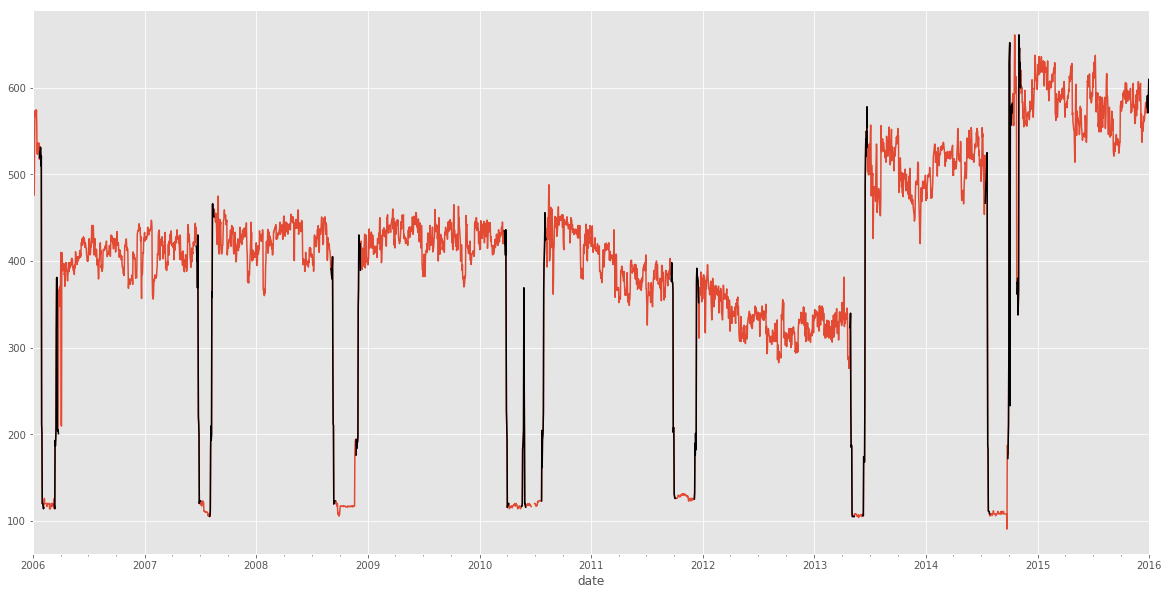

In [121]:
print("computation on DEB1")
print(len(df_deb1_1))
increase_trend = segment_data(df_deb1_1,(int)(len(df_deb1_1)/10000),5)
print(increase_trend)
printCat(df_deb1_1,increase_trend)
print(np.mean(df_deb1_1))


computation on DEB2
finding transitoire subsection...
transitoire subsection found, len of result:
17
finding interval seperating point...
interval seperating point found, len or result:
15
remove interval accordingly to low value interval...
interval of low value removed, final len of result:
15
[(9868, 11868), (76584, 78584), (82824, 84824), (139764, 141764), (151516, 153516), (221196, 223196), (228996, 230996), (236952, 238952), (297896, 299896), (308660, 310660), (381408, 383408), (388064, 390064), (445732, 447732), (455716, 457716), (521652, 522688)]
432.257143426


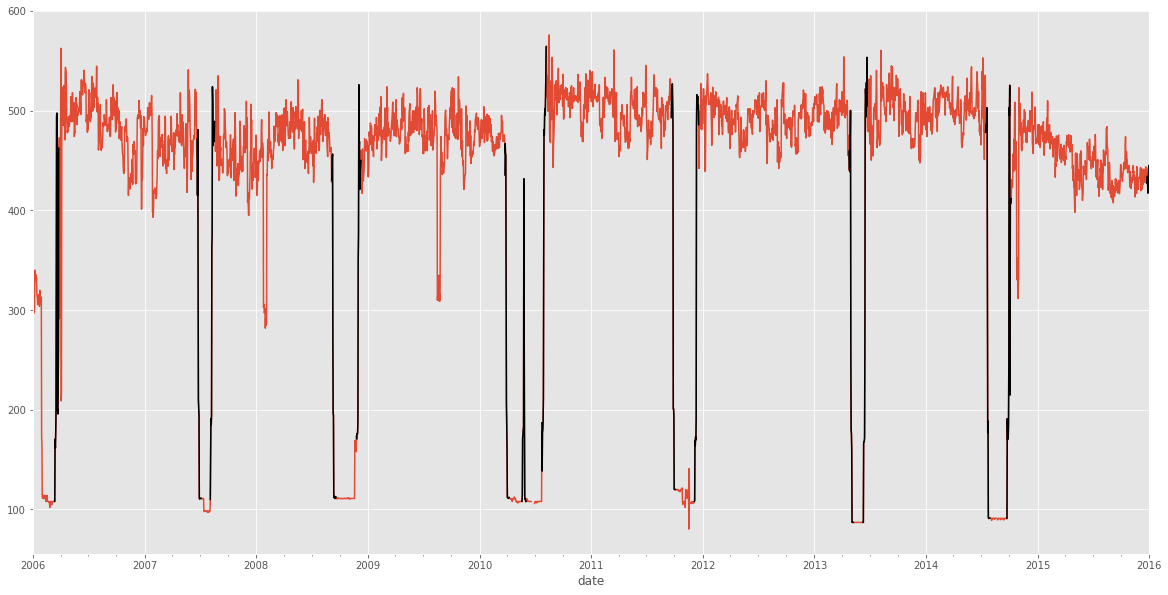

In [122]:
print("computation on DEB2")
increase_trend_2 = segment_data(df_deb1_2,(int)(len(df_deb1_2)/10000),5)
printCat(df_deb1_2,increase_trend_2)
print(increase_trend_2)
print(np.mean(df_deb1_2))

number of critical pattern:
3
begining value:
DEB1-1    104.727272
DEB1-2    102.000000
Name: 2007-08-01 13:00:00, dtype: float64
ending value:
DEB1-1    459.0
DEB1-2    474.0
Name: 2007-08-15 10:20:00, dtype: float64
strong increasing variation


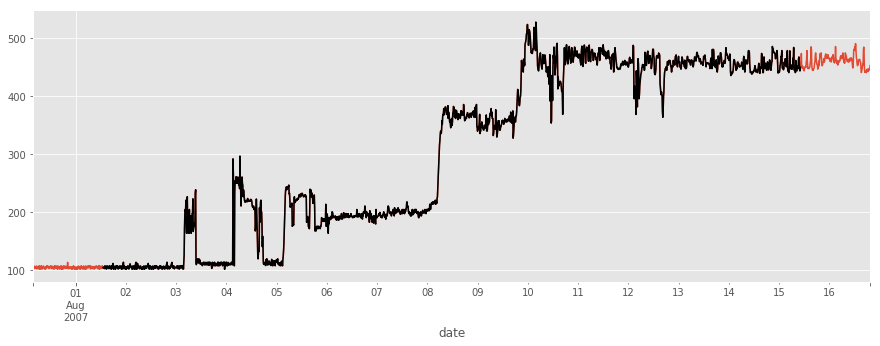

In [124]:
currentDisplay = 0

toggle_widget = ToggleButton(
    value=False,
    description='Tight Layout',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='check'
)


def printPattern(data, familly, currentDisp):
    
    margin = 100
    print('number of critical pattern:')
    print(currentDisp)
    print('begining value:')
    print(df.iloc[familly[currentDisp][0]])
    print('ending value:')
    print(df.iloc[familly[currentDisp][1]])
    if (data.iloc[familly[currentDisp][0]] < data.iloc[familly[currentDisp][1]]):
        print("strong increasing variation")
    else:
        print("strong decreasing variation")
    subToPrint = select_from_to(data, familly[currentDisp][0] - 200, familly[currentDisp][1] + 200)
    interestPart = select_from_to(data, familly[currentDisp][0], familly[currentDisp][1])
    subToPrint.plot(figsize=(15,5))
    interestPart.plot(figsize=(15,5),color='black')


def nextFamilly(t):
    clear_output()
    global currentDisplay
    currentDisplay = currentDisplay + 1 
    if (currentDisplay >= len(increase_trend)):
        currentDisplay = currentDisplay - 1
    printPattern(df_deb1_1, increase_trend, currentDisplay)
        
def previousFamilly(t):
    clear_output()
    global currentDisplay
    currentDisplay = currentDisplay - 1 
    if (currentDisplay < 0):
        currentDisplay = currentDisplay + 1
    printPattern(df_deb1_1, increase_trend, currentDisplay)   

    



btn_up = Button(description='next pattern',disabled=False,button_style='success',
                    tooltip='next pattern familly found')
btn_down = Button(description='previous pattern',disabled=False,button_style='warning', 
                    tooltip='previous pattern familly found')


display(btn_up)
display(btn_down)
btn_up.on_click(nextFamilly)
btn_down.on_click(previousFamilly)


We can see that this algorithm return each subsection related to a high varation in the dataframe. Most of these variations are the consequences of a state of the reactors. Indeed, for a value near 200, we assume that the reactor is OFF. On the other hand, a value around 400 means that the reators is ON. with a specific value for the  parameter rate in the algorithm find_trans, we detect the transition from 400 to 200. So this is a turn ON/OFF, or OFF,ON of the reactor. 

the parameter is chosen according to the lenght of the dataframe and the difference between the minimum and the maximum of the time series. So this algorithm can work on several time series which have other maximum and minimum value than 200 and 400.